In [1]:
import pandas as pd
import numpy as np
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn import metrics 

import sys
# sys.path.insert(0, '')
import importlib
from dredFISH.Analysis import basicu

importlib.reload(basicu)

sns.set_context('talk')

# Load data

In [2]:
f = '../data_dump/candidate_genes_vincent_0328.csv'
df0 = pd.read_csv(f)
df0 = df0.sort_values(['Subclass', 'Type/Gradient'])
df0 = df0[df0['Gene']!='Neurod1']
df0 = df0.set_index('Gene')
df0

,Subclass,Type/Gradient,Function,Priority,Note
Gene,,,,,
Baz1a,L2/3,A<B>C,TF,***,NaN
Trpc6,L2/3,A<B>C,IC,***,NaN
Bdnf,L2/3,A<B>C,CAM,***,NaN
Sox5,L2/3,A<B>C,TF,NaN,NaN
Nrp1,L2/3,A<B>C,CAM,***,NaN
...,...,...,...,...,...
Ngb,L2/3,NaN,other,NaN,NaN
Penk,L2/3,NaN,other,NaN,NaN
Chrm2,"L2/3, L4",C>B=A,IC,***,NaN


In [3]:
%%time
adata = ad.read('../data_dump/P38_glut_genes_v2_annot.h5ad')
adata

CPU times: user 239 ms, sys: 469 ms, total: 708 ms
Wall time: 1.62 s


AnnData object with n_obs × n_vars = 5837 × 86
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'layer', 'Type', 'Subclass', 'embed_1', 'embed_2', 'PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7', 'PC_8', 'PC_9', 'PC_10', 'PC_11', 'PC_12', 'PC_13', 'PC_14', 'PC_15', 'PC_16', 'PC_17', 'PC_18', 'PC_19', 'PC_20', 'PC_21', 'PC_22', 'PC_23', 'PC_24', 'PC_25', 'PC_26', 'PC_27', 'PC_28', 'PC_29', 'PC_30', 'PC_31', 'PC_32', 'PC_33', 'PC_34', 'PC_35', 'PC_36', 'PC_37', 'PC_38', 'PC_39', 'PC_40', 'PC_41', 'PC_42', 'PC_43', 'PC_44', 'PC_45', 'PC_46', 'PC_47', 'PC_48', 'PC_49', 'PC_50', 'PC_51', 'PC_52', 'PC_53', 'PC_54', 'PC_55', 'PC_56', 'PC_57', 'PC_58', 'PC_59', 'PC_60', 'PC_61', 'PC_62', 'PC_63', 'PC_64', 'PC_65', 'PC_66', 'PC_67', 'PC_68', 'PC_69', 'PC_70', 'PC_71', 'PC_72', 'PC_73', 'PC_74', 'PC_75', 'PC_76', 'PC_77', 'PC_78', 'PC_79', 'PC_80', 'PC_81', 'PC_82', 'PC_83', 'PC_84', 'PC_8

In [4]:
adata.layers

Layers with keys: 

In [4]:
# ## classsification based off the ~86 genes (Try LASSO for the minimum set of genes)
# - L2/3 vs L4
# - L2/3 subtypes
# - continuum (UMAP_1 as a proxy)

In [5]:
# def classifier_pipe(X, y):
#     kf = KFold(n_splits=5, shuffle=True, random_state=0)
#     ps = []
#     rs = []
#     auprs = []
#     for train_idx, test_idx, in kf.split(X):
#         X_train, X_test = X[train_idx], X[test_idx]
#         y_train, y_test = y[train_idx], y[test_idx]

#         # train
#         lrf = LogisticRegression(random_state=0).fit(X_train,y_train)
#         # test
#         yp = lrf.predict_proba(X_test)
#         # evaluation
#         p, r, th = metrics.precision_recall_curve(y_test.values.astype(int), yp[:,1])
#         pidx = np.argsort(p)
#         p = p[pidx]
#         r = r[pidx]

#         p = np.hstack([0, p, 1])
#         r = np.hstack([1, r, 0])
#         aupr = metrics.auc(p, r)

#         ps.append(p)
#         rs.append(r)
#         auprs.append(aupr)
#     return ps, rs, auprs

# def plot_pipe(ax, ps, rs, auprs):
#     for p, r in zip(ps, rs):
#         ax.plot(r, p, color='C0', linewidth=1)
#     ax.text(0,0, f"AUPR={np.mean(auprs):.2f}\n(mean over 5-fold CV)")
#     sns.despine(ax=ax)
#     ax.set_aspect('equal')
#     ax.set_xticks(np.linspace(0,1,6))
#     ax.set_yticks(np.linspace(0,1,6))
#     ax.set_xlabel('Recall')
#     ax.set_ylabel('Precision')
#     return ax

In [6]:
def get_precision_recall(y_true, y_pred):
    """Auto system; has some edge case issues
    """
    p, r, th = metrics.precision_recall_curve(y_true, y_pred)
    # pidx = np.argsort(p)
    # p = p[pidx]
    # r = r[pidx]
    # p = np.hstack([0, p, 1])
    # r = np.hstack([1, r, 0])
    return p, r

def get_precision_recall_v2(y_true, y_pred):
    """Auto system; has some edge case issues
    """
    pth = np.linspace(0,1,101)
    p = []
    r = []
    for pth1 in pth:
        conf = metrics.confusion_matrix(y_true, y_pred>pth)
        tn, fp, fn, tp = conf.ravel()
        p1 = tp/(tp+fp)
        r1 = tp/(tp+fn)
        p.append(p1)
        r.append(r1)
    
    return p, r

def evaluate(y_true, y_pred, pr_opt='v1'):
    """
    """
    # evaluation
    if pr_opt == 'v1':
        p, r = get_precision_recall(y_true, y_pred)
    elif pr_opt == 'v2':
        p, r = get_precision_recall_v2(y_true, y_pred)
    aupr = metrics.auc(r, p)
    # aupr = -1
    return p, r, aupr

def classifier_pipe(X, y, c=1):
    """
    """
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    ps = []
    rs = []
    auprs = []
    
    y_true = np.empty(len(y))
    y_pred = np.empty(len(y))
    
    
    l0s = []
    l1s = []
    for train_idx, test_idx, in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # train
        model = LogisticRegression(penalty='l1', solver='liblinear', C=c, random_state=0)
        # model = LogisticRegression(random_state=0)
        model.fit(X_train, y_train)
        
        # test
        yp = model.predict_proba(X_test)
        
        # results
        l0 = (np.abs(model.coef_) > 1e-6).sum() 
        l1 = np.abs(model.coef_).sum()
        l0s.append(l0)
        l1s.append(l1)
        
        # results
        y_true[test_idx] = y_test.values.astype(int)
        y_pred[test_idx] = yp[:,1]
        
        
    return y_true, y_pred, l0s, l1s

def plot_pipe(ax, y_true, y_pred, pr_opt='v1'):
    """
    """
    ps, rs, aupr = evaluate(y_true, y_pred, pr_opt=pr_opt) 
    
    ax.plot(rs, ps, color='C0', linewidth=2)
    ax.text(0,0.1, f"AUPR={aupr:.2f}")
    sns.despine(ax=ax)
    ax.set_aspect('equal')
    ax.set_xticks(np.linspace(0,1,6))
    ax.set_yticks(np.linspace(0,1,6))
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    return ax

# L2/3 vs L4

In [7]:
# data
X = adata.X
y = adata.obs['cluster'].str.contains('L2/3')
print(X.shape, y.shape)

# run
y_true, y_pred, l0s, l1s = classifier_pipe(X, y, c=1)

(5837, 86) (5837,)


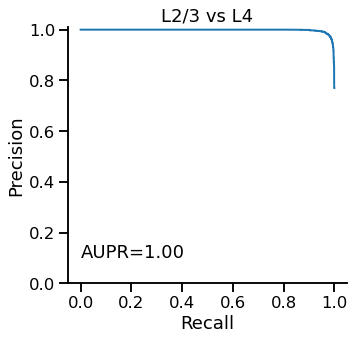

In [8]:
# vis
fig, ax = plt.subplots(1,1,figsize=(5*1,5))
plot_pipe(ax, y_true, y_pred, pr_opt='v1')
ax.set_title(f'L2/3 vs L4')
plt.show()

# within L2/3

In [9]:
# data
cond = adata.obs['cluster'].str.contains('L2/3')
adatasub = adata[cond].copy()
X = adatasub.X

y_a = adatasub.obs['cluster'].str.contains('L2/3_A') 
y_b = adatasub.obs['cluster'].str.contains('L2/3_B') 
y_c = adatasub.obs['cluster'].str.contains('L2/3_C') 
print(X.shape, y_a.shape, y_b.shape, y_c.shape)

(2818, 86) (2818,) (2818,) (2818,)


In [18]:
y_true_a, y_pred_a, _, _ = classifier_pipe(X, y_a, c=1)
y_true_b, y_pred_b, _, _ = classifier_pipe(X, y_b, c=1)
y_true_c, y_pred_c, _, _ = classifier_pipe(X, y_c, c=1)

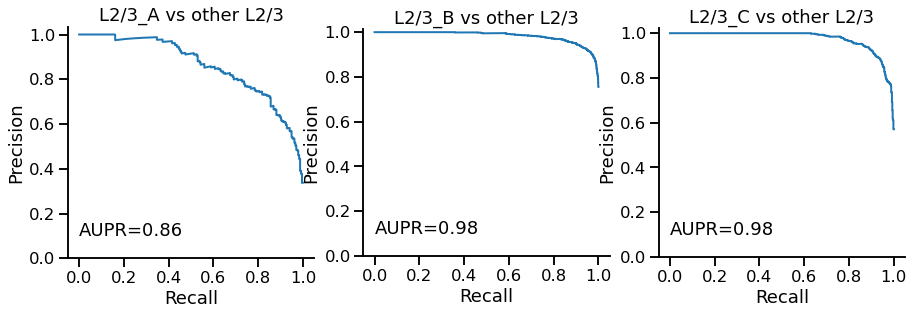

In [19]:
fig, axs = plt.subplots(1,3,figsize=(5*3,5))
ax = axs[0]
plot_pipe(ax, y_true_a, y_pred_a)
ax.set_title(f'L2/3_A vs other L2/3')

ax = axs[1]
plot_pipe(ax, y_true_b, y_pred_b)
ax.set_title(f'L2/3_B vs other L2/3')

ax = axs[2]
plot_pipe(ax, y_true_c, y_pred_c)
ax.set_title(f'L2/3_C vs other L2/3')
plt.show()